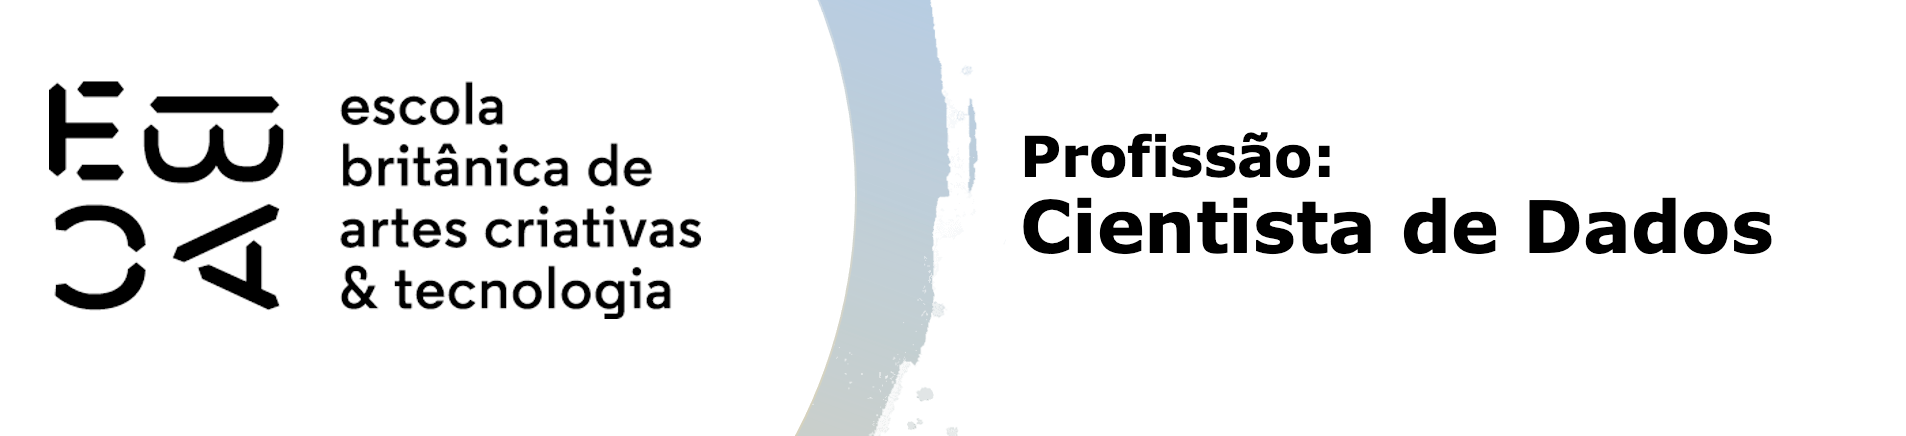

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

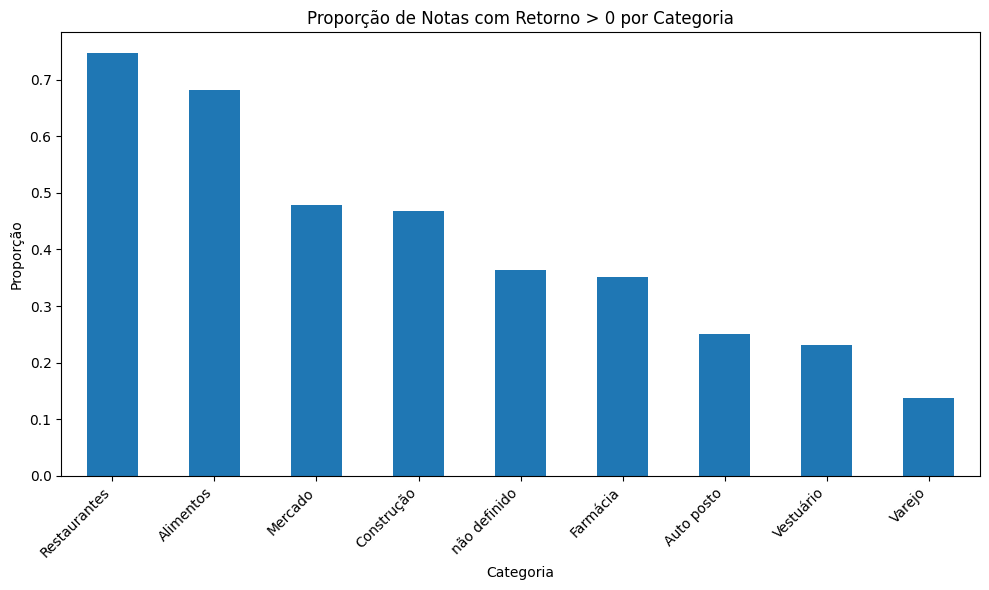

In [3]:
# Filtrando os dados para janeiro de 2020 em diante
df = df[df['Data Emissão'] >= '2020-01-01']

# Filtrando os dados para notas com retorno maior que zero
df_positive_return = df[df['Retorno'] > 0]

# Contando a proporção de notas com retorno maior que zero por categoria
return_by_category = df_positive_return.groupby('categoria')['No.'].count() / df.groupby('categoria')['No.'].count()

# Ordenando por proporção descendente
return_by_category = return_by_category.sort_values(ascending=False)

# Plotando um gráfico de barras
plt.figure(figsize=(10, 6))
return_by_category.plot(kind='bar')
plt.title('Proporção de Notas com Retorno > 0 por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Proporção')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

              Positives  Total  Negatives       WOE
categoria                                          
Varejo              701   5066       4365 -1.543585
Vestuário           443   1920       1477 -0.918918
Auto posto          135    540        405 -0.813331
Farmácia           3582  10189       6607 -0.326928
não definido       6689  18407      11718 -0.275381
Construção         7523  16047       8524  0.160360
Mercado           13177  27558      14381  0.197846
Alimentos          3442   5050       1608  1.046342
Restaurantes       1626   2179        553  1.363801


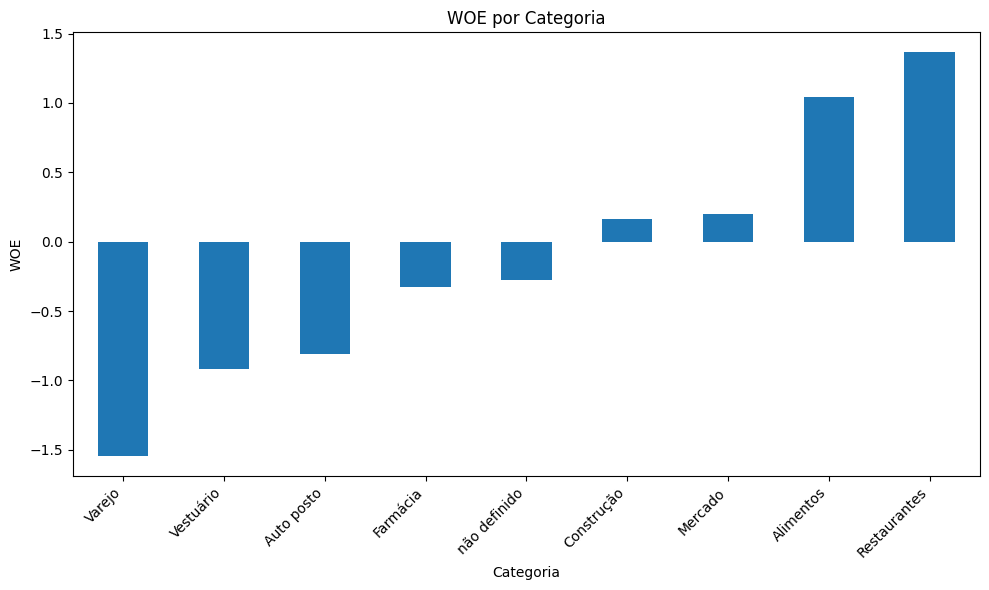

In [6]:
# Criando uma variável para indicar se a nota teve retorno maior que zero
df['HasPositiveReturn'] = (df['Retorno'] > 0).astype(int)

# Calculando o WOE por categoria
woe_by_category = df.groupby('categoria').agg({'HasPositiveReturn': ['sum', 'count']})
woe_by_category.columns = ['Positives', 'Total']
woe_by_category['Negatives'] = woe_by_category['Total'] - woe_by_category['Positives']
woe_by_category['WOE'] = np.log((woe_by_category['Positives'] / woe_by_category['Negatives']) / (woe_by_category['Positives'].sum() / woe_by_category['Negatives'].sum()))

# Ordenando por WOE ascendente
woe_by_category = woe_by_category.sort_values(by='WOE')

# Exibindo a tabela de WOE por categoria
print(woe_by_category)

# Plotando um gráfico de barras para o WOE por categoria
plt.figure(figsize=(10, 6))
woe_by_category['WOE'].plot(kind='bar')
plt.title('WOE por Categoria')
plt.xlabel('Categoria')
plt.ylabel('WOE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [7]:
# Criando uma variável para indicar se a nota teve retorno maior que zero
df['HasPositiveReturn'] = (df['Retorno'] > 0).astype(int)

# Calculando o IV por categoria
iv_by_category = df.groupby('categoria').agg({'HasPositiveReturn': ['sum', 'count']})
iv_by_category.columns = ['Positives', 'Total']
iv_by_category['Negatives'] = iv_by_category['Total'] - iv_by_category['Positives']
iv_by_category['Distribution_Pos'] = iv_by_category['Positives'] / iv_by_category['Positives'].sum()
iv_by_category['Distribution_Neg'] = iv_by_category['Negatives'] / iv_by_category['Negatives'].sum()
iv_by_category['WOE'] = np.log(iv_by_category['Distribution_Pos'] / iv_by_category['Distribution_Neg'])
iv_by_category['IV'] = (iv_by_category['Distribution_Pos'] - iv_by_category['Distribution_Neg']) * iv_by_category['WOE']

# Calculando o IV total
total_iv = iv_by_category['IV'].sum()

# Exibindo a tabela de IV por categoria
print(iv_by_category[['IV']].sort_values(by='IV', ascending=False))

# Exibindo o IV total
print(f"IV Total: {total_iv}")


                    IV
categoria             
Varejo        0.106742
Alimentos     0.062613
Restaurantes  0.044229
Vestuário     0.016434
não definido  0.015649
Mercado       0.012540
Farmácia      0.012135
Construção    0.004790
Auto posto    0.003694
IV Total: 0.27882574285237305


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


> * <span style="font-family: Serif; color: green;">A partir dos resultados que obtivemos após os cálculos e análises do WOE e do IV, podemos concluir que as categorias "Varejo", "Alimentos" e "Restaurantes" possuem valores mais relevantes de IV, ou seja, indicam que elas são mais informativas para prever notas com retorno maior do que zero, tendo um poder de previsõa significativo em relação ao evento de interesse, as categorias de "Vestuário", "Farmácia" e "Não Definido" tem valores intermediários, indicando que elas possuem um poder de previsão não tão forte quanto as anteriores, mas ainda sim relevantes, já as categorias "Auto Posto" e "Construção" têm valores mais baixos de IV sugerindo que elas tem um poder menor de previsão, não descartando a possibilidade de essas categorias contribuirem para a previsão quando combinadas a outras informações.</span>